<a href="https://colab.research.google.com/github/78furu/deeplea_adv/blob/master/deeplea_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/github_repos/deeplea_adv/'
%pwd
! git pull

import unet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/github_repos/deeplea_adv
Already up to date.


In [43]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import preproc as pp
from models import Score
from collections import namedtuple
import pickle
import time

print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Pytorch version: 1.8.1+cu101
Using GPU device: Tesla T4


In [42]:
my_tuple = pp.generate_config_namedtuple(open(r'scorenet.yml'))
net = Score(my_tuple)
MODEL = net.to(torch.cuda.current_device())
MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)

length = 10
ratio = pow(0.01/10, 1/9)
start = 10
progression = np.array([start * ratio**i for i in range(length)])
epses = np.logspace(-5, -1, 9)

Dataset: mnist 
 Image shape: (1, 28, 28) 
 Number of train images: 60000 
 Number of test images: 10000 
 Number of classes: 10 



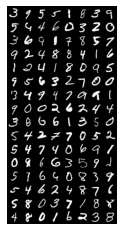

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

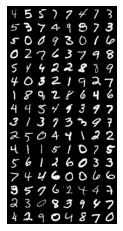

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

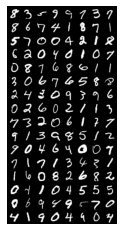

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

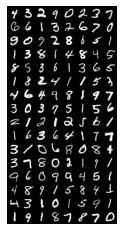

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

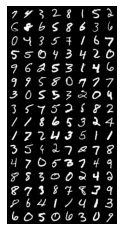

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

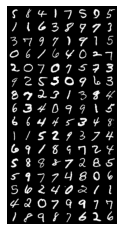

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

In [ ]:
t = time.time()
DATASET_NAME = 'mnist'

# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-3)  
BATCH_SIZE = 128  
NUM_EPOCHS = 50
sigmas_ = progression
all_all_pics = {}

for sig in sigmas_:
    MODEL, loss_and_accuracy_history = pp.training_and_eval(DATASET_NAME, 
                                                                MODEL,
                                                                OPTIMIZER,
                                                                BATCH_SIZE, 
                                                                NUM_EPOCHS,
                                                                augment = False, 
                                                                need_summary = True,
                                                                sigma=sig)
    all_pics = pp.annealed_langevin(MODEL, progression, T = 100)
    all_all_pics[sig] = all_pics
    pickle.dump(all_all_pics, open("all_all_pics_from_big_to_small.p", "wb"))
    torch.save(MODEL.state_dict(), f"model_params_training_from_big_to_small_sigma_{sig:.2f}_50_epoch_each.pt")

    print(f'\n\n\n#######################\nsig {sig} done in  {time.time()-t} secs \n\n')

In [ ]:
torch.save(MODEL.state_dict(), "model_params_2_all_trained_for210_epochs.pt")

In [14]:
all_all_pics = pickle.load(open("all_all_pics.p", 'rb'))

In [30]:
c = -1
all_pics = all_all_pics[progression[c]]


for k, v in all_all_pics.items():
    all_pics.append(v[2])

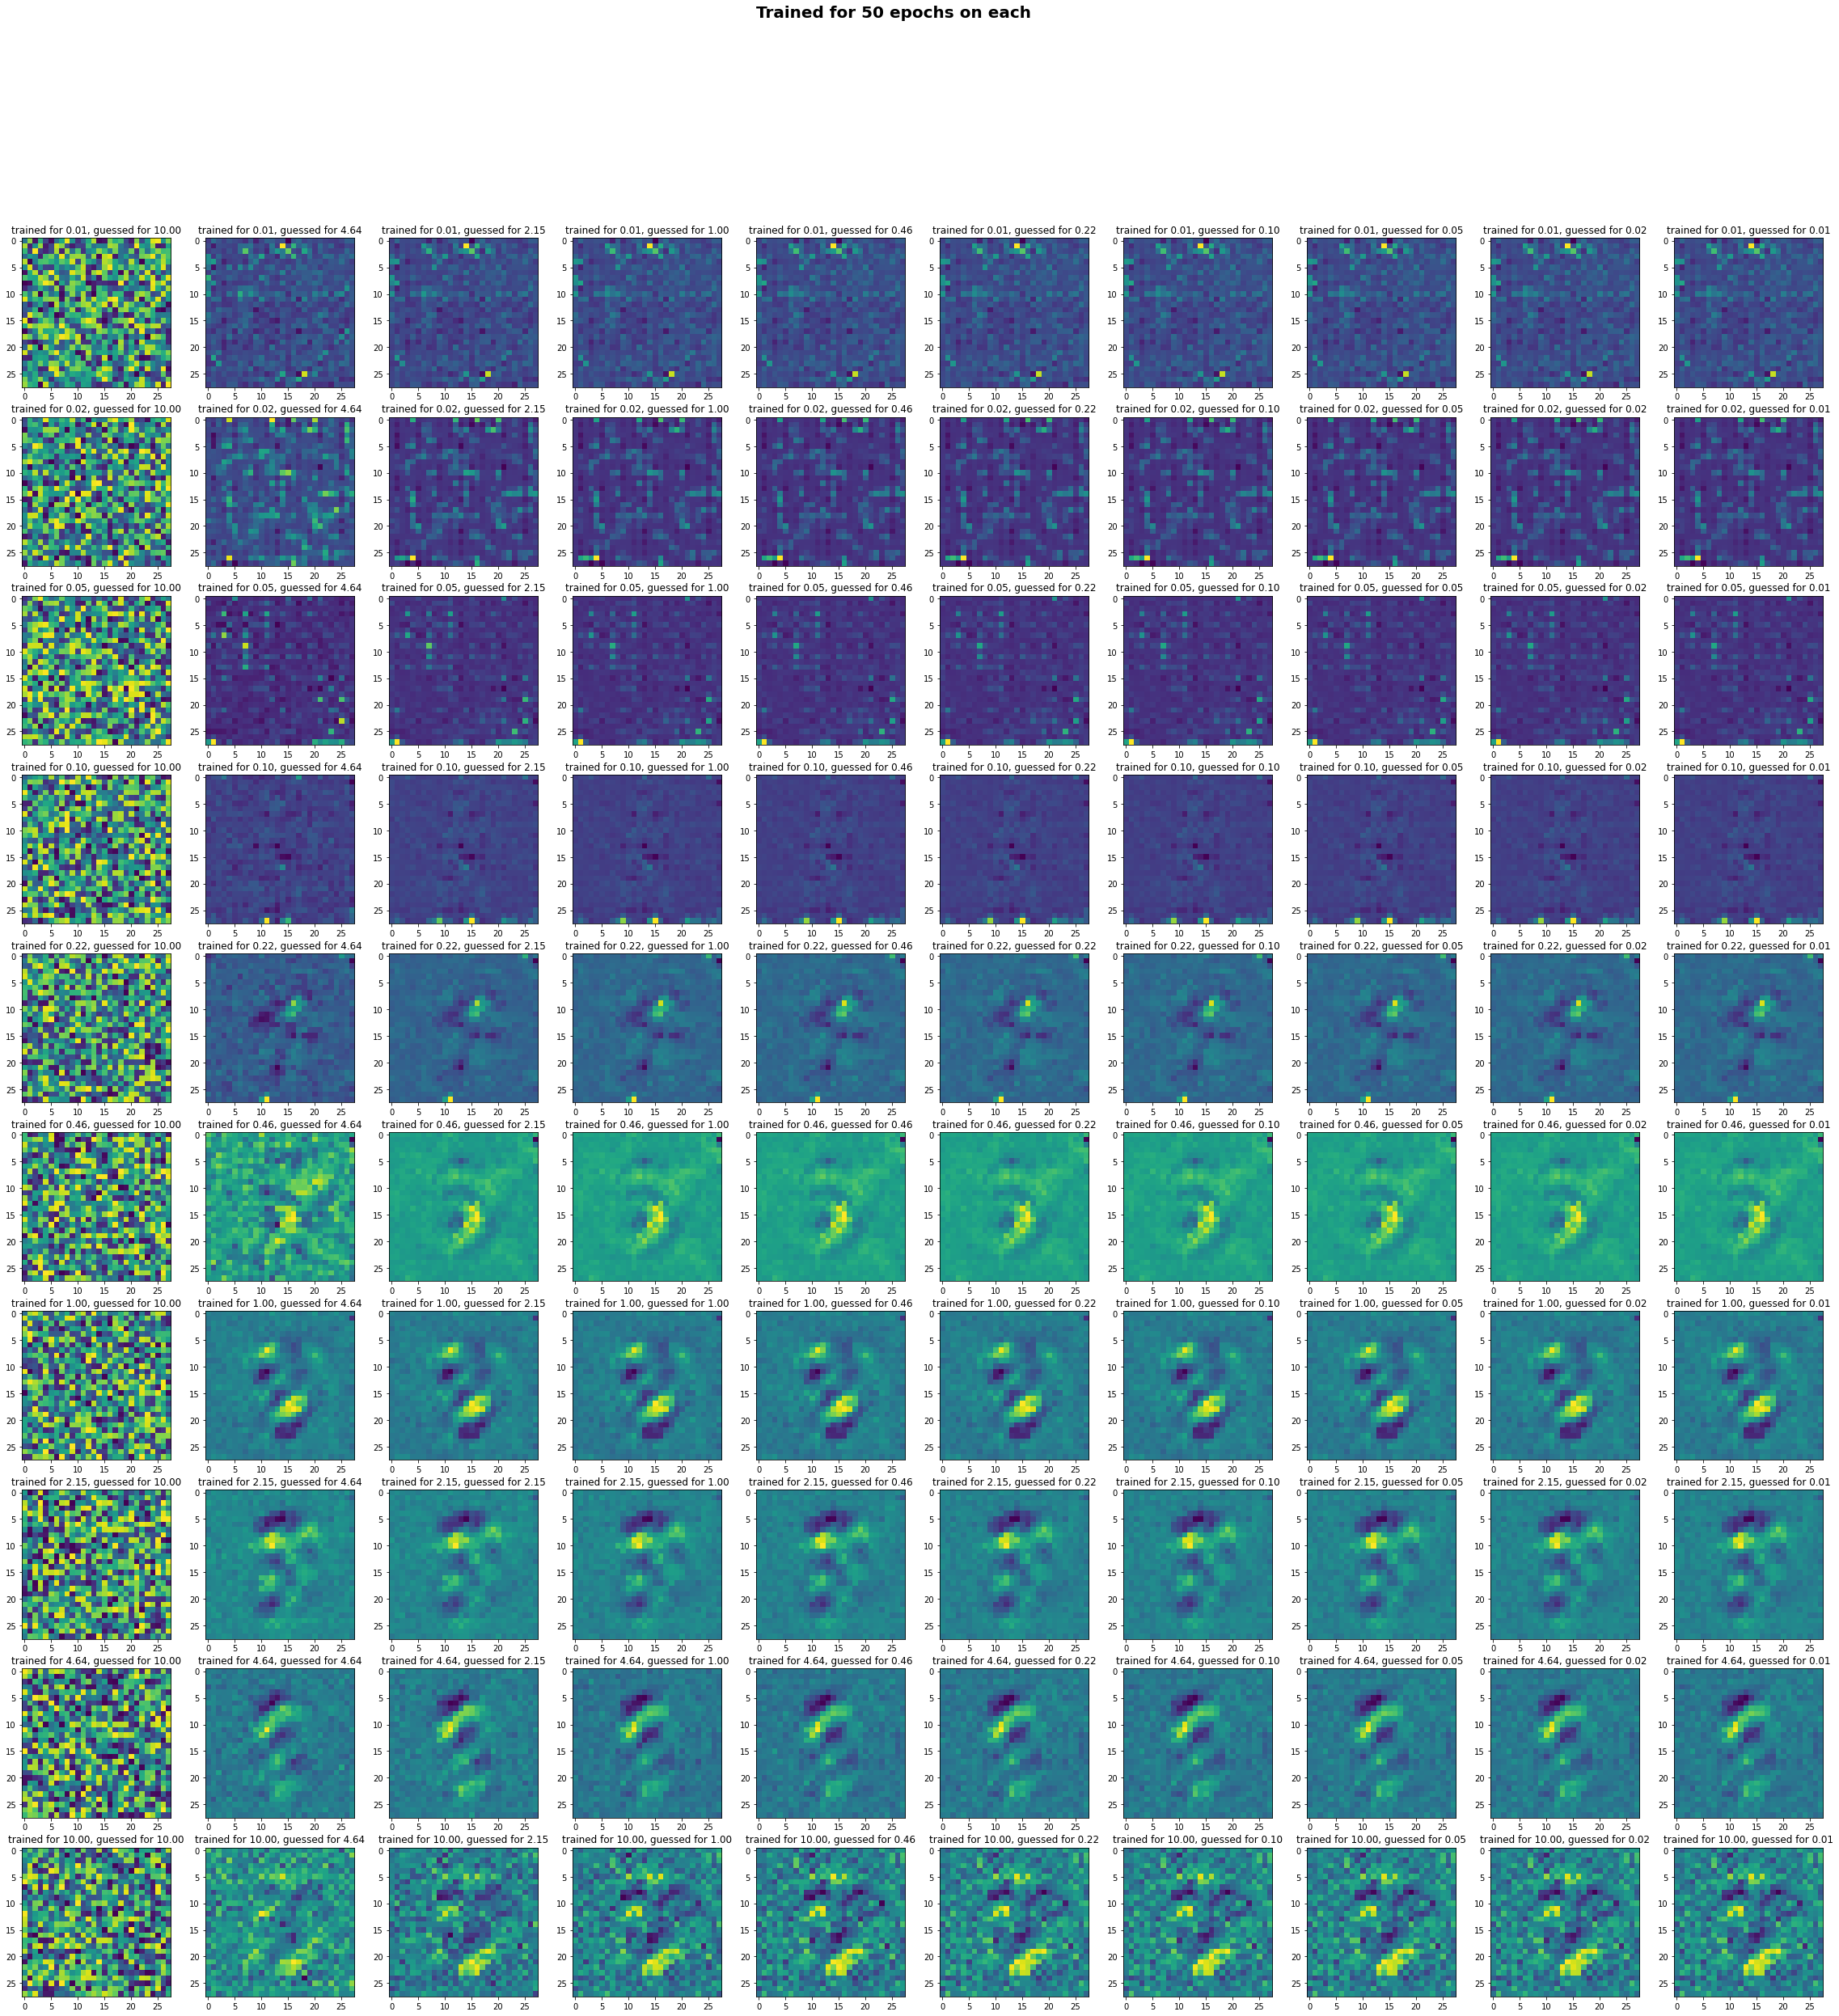

In [37]:
fig, axes = plt.subplots(10,10, figsize=(40, 40))


for r, s_tr  in enumerate(progression[::-1]):
    for c, s_gu in enumerate(progression):
        ax = axes[r,c]
        im = all_all_pics[s_tr][c]
        ax.imshow(im)
        ax.set_title(f"trained for {s_tr:.2f}, guessed for {s_gu:.2f}")
fig.suptitle("Trained for 50 epochs on each", fontsize=20, fontweight = 'bold')
fig.savefig('trained_on_all_from_small_to_big_for_50_epochs.png', dpi = 100)

## Data loading

In [ ]:
train, test = pp.load_and_preprocess_data("mnist", BATCH_SIZE)

NameError: ignored

In [ ]:
outp = MODEL((train.dataset.data[:32].view(32, 1, 28, 28)/255).to("cuda"))

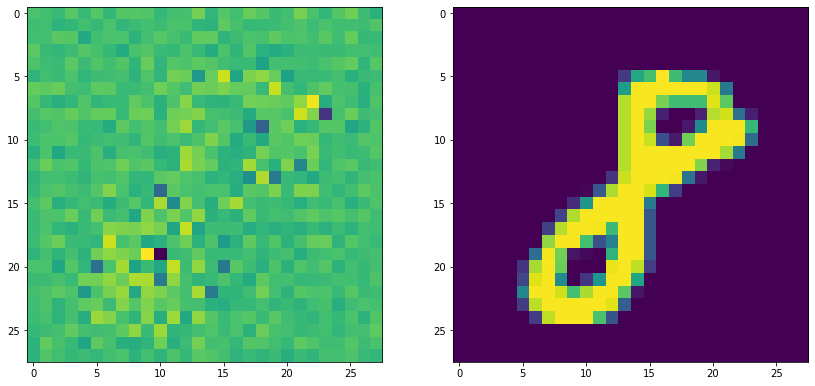

In [ ]:
c = 31
image = outp[c].detach().cpu().numpy().astype(float)

fig, axes = plt.subplots(1,2, figsize=(14, 8))

ax = axes[0]
#ax.imshow(np.moveaxis(image, [0,1,2], [2,0,1]))
ax.imshow(image[0])
ax = axes[1]
ax.imshow(train.dataset.data[c])

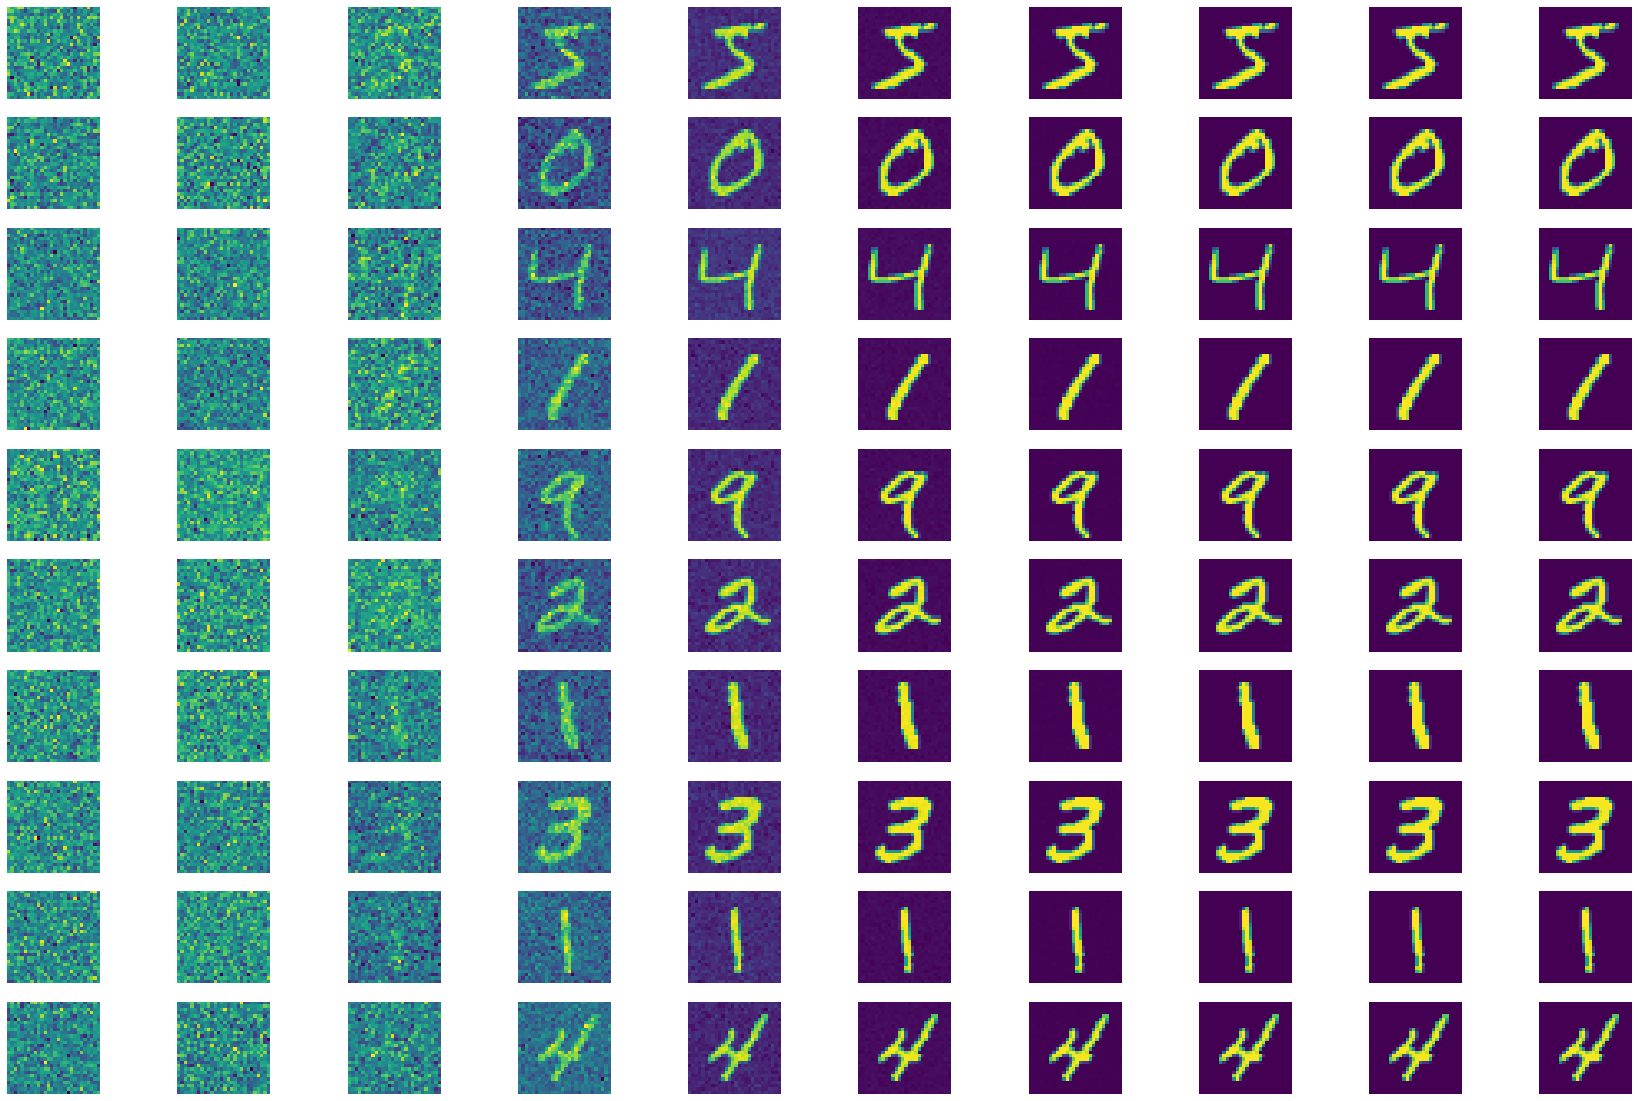

In [ ]:


fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow(im_);
        ax.axis('off')

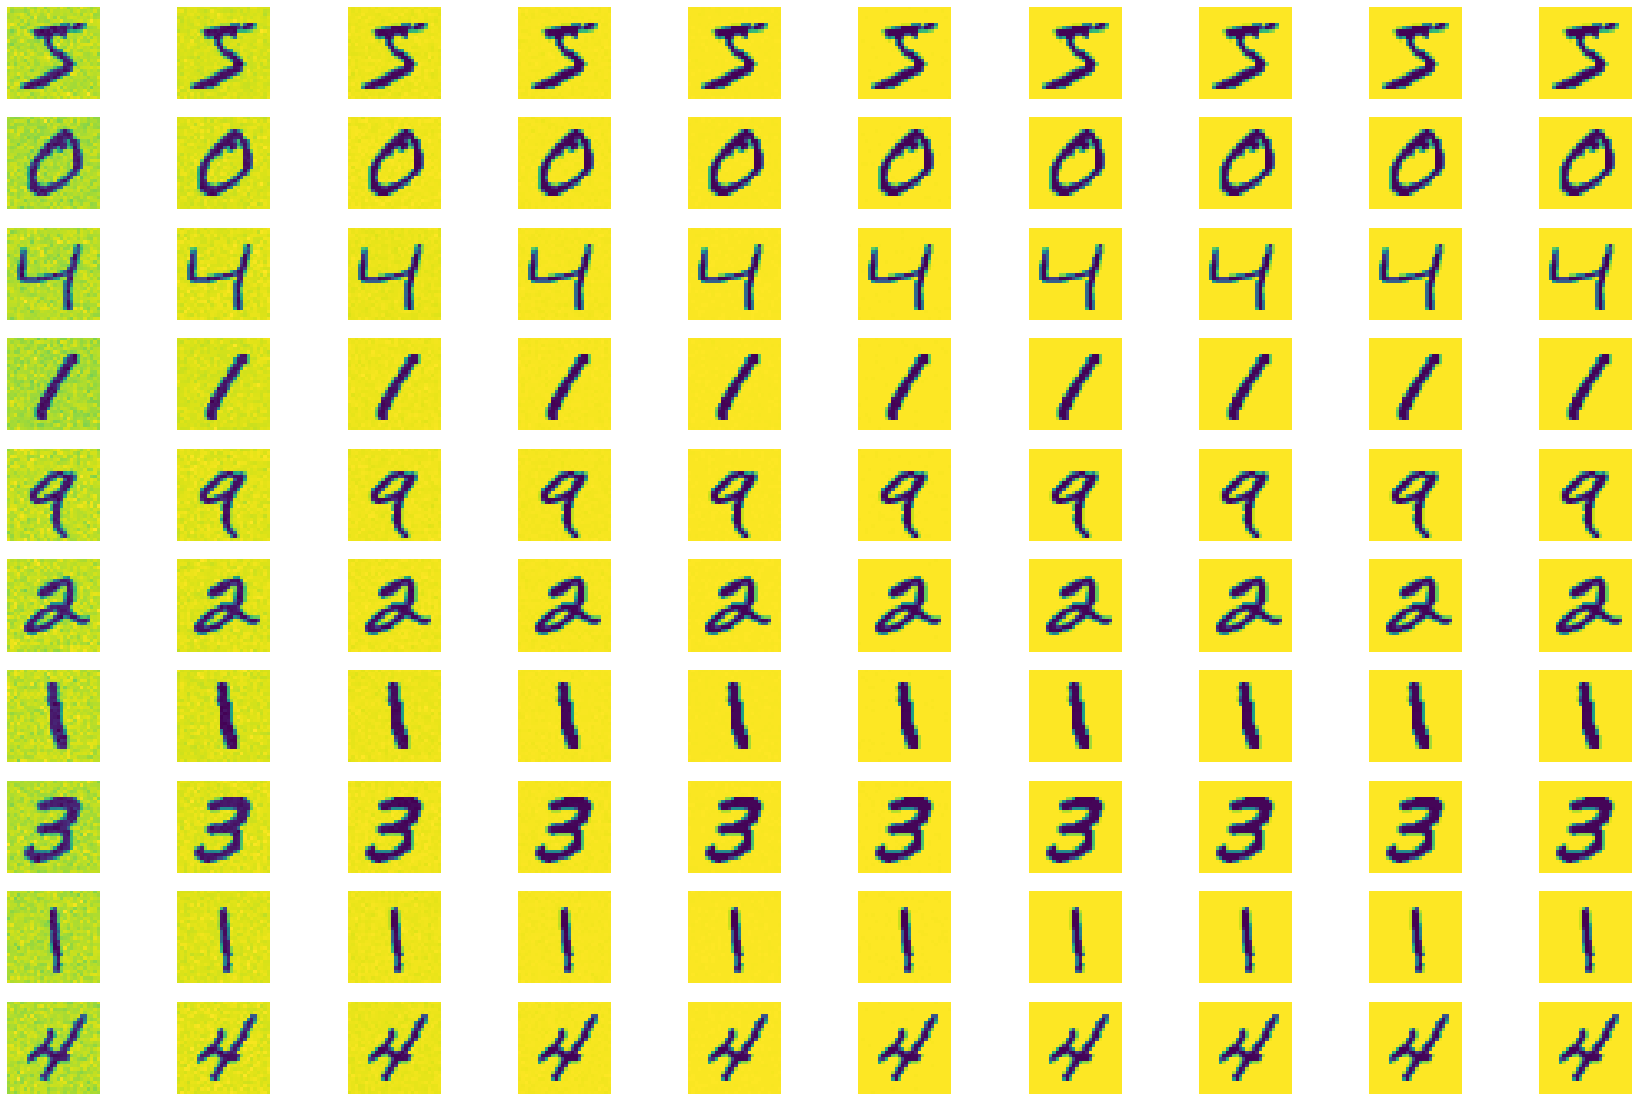

In [ ]:
fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps_ = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow((im_-im)/eps);
        ax.axis('off')

In [ ]:
device = torch.cuda.current_device()
for sigma in epses:

    for i, (images, labels) in enumerate(train):
        images_o = images.to(device)
        #eps_ = (eps**2/progression[-1]**2)*2e-5
        images = images_o + torch.normal(0, std=sigma, size=images.shape).to(device)
        labels = (images-images_o)/sigma

KeyboardInterrupt: ignored

In [ ]:
gen_images = [annealed_langevin(MODEL,progression,e, 100)[0][0].cpu().detach().numpy() for e in epsilons]
#gen_images = [annealed_langevin(MODEL,progression,epsilons[-1], t)[0][0].cpu().detach().numpy() for t in t_s]

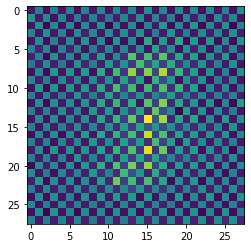

In [ ]:
c = annealed_langevin(loaded_model,progression,2e-5, 100)
plt.imshow(c[0][0].cpu().detach().numpy())

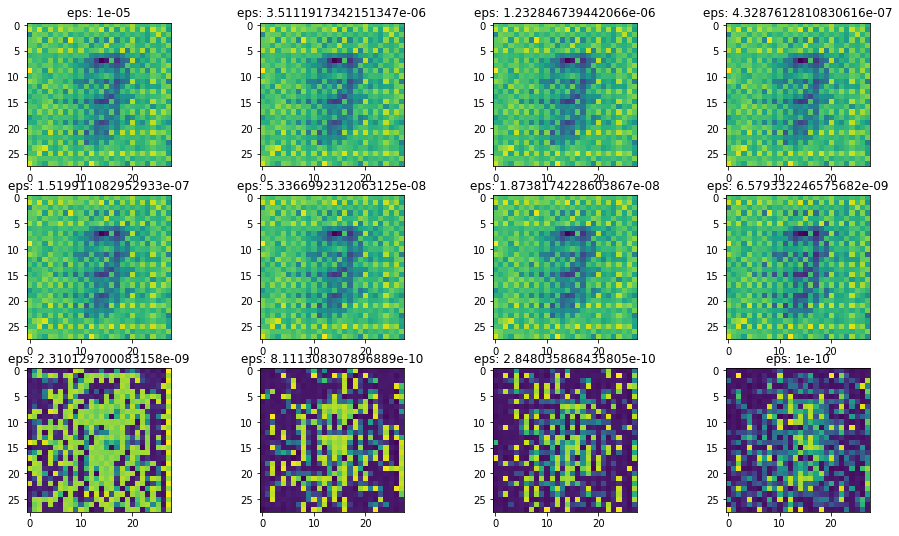

In [ ]:
fig, axes = plt.subplots(3,4, figsize = (16,9))

for im, ax, ep in zip(gen_images, axes.ravel(), epsilons):
    ax.imshow(im)
    ax.set_title(f"eps: {ep}")

fig.savefig('figs/different_epses_appr_310_epochs_for_allsigmas_plus_10sigma.png', dpi = 100)

In [ ]:
progression

array([10.        ,  4.64158883,  2.15443469,  1.        ,  0.46415888,
        0.21544347,  0.1       ,  0.04641589,  0.02154435,  0.01      ])

In [ ]:
    torch.cuda.empty_cache()

In [ ]:
# torch.save(MODEL.state_dict(), "model_params_2_all_trained_for160_epochs.pt")

In [7]:
"""MODEL = Score(my_tuple)
MODEL = MODEL.to(torch.cuda.current_device())
MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)
MODEL.load_state_dict(torch.load("model_params_2_all_trained_for310_epochs_sig10_added.pt"))
""";

In [9]:

!git push

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 813 bytes | 406.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/78furu/deeplea_adv.git
   2efd67a..79628d9  master -> master
